#1.Improt Library

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import pickle

# =========================
# Scikit-learn
# =========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =========================
# LSTM
# =========================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# DistilBERT
# =========================
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from transformers import AutoModelForSequenceClassification

# =========================
# BERT
# =========================
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import TrainingArguments, Trainer

# =========================
# HuggingFace Datasets
# =========================
from datasets import Dataset


#2.Load Dataset

In [ ]:
DATA_PATH = '/content/Dataset Uap.csv'
df = pd.read_csv(DATA_PATH)

print("Dataset Loaded!")
df.head()

Dataset Loaded!


,original_text,final_text,sentiment,sentiment_label,__index_level_0__
0,@urmoodboostyy @balabalabilibul @prillyyla @pr...,"hahaha emang bner orang desa ga main saham, ud...",1,neutral,6014
1,gak pernah terbayang di pikiran gua presiden i...,gak pernah terbayang di pikiran gua presiden i...,1,neutral,418
2,"Aelah pantes komen2 si pro pada ""yaelah baru 1...","aelah pantes komen2 si pro pada ""yaelah baru 1...",2,positive,1210
3,@48RequestHour MOT sama JOT gaada bedanya ini ...,mot sama jot gaada bedanya ini 48g kebanyakan ...,2,positive,3475
4,@lulukhamidah Layak masuk dalam daftar reshufl...,layak masuk dalam daftar reshuflle 100 hari ki...,2,positive,3611


#3.Informasi Dataset

In [ ]:
print("Jumlah Baris :", df.shape[0])
print("Jumlah Kolom :", df.shape[1])

Jumlah Baris : 8030
Jumlah Kolom : 5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8030 entries, 0 to 8029
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_text      8028 non-null   object
 1   final_text         7959 non-null   object
 2   sentiment          8030 non-null   int64 
 3   sentiment_label    8030 non-null   object
 4   __index_level_0__  8030 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 313.8+ KB


In [ ]:
print("\n5 data teratas:")
display(df.head())


5 data teratas:


,original_text,final_text,sentiment,sentiment_label,__index_level_0__
0,@urmoodboostyy @balabalabilibul @prillyyla @pr...,"hahaha emang bner orang desa ga main saham, ud...",1,neutral,6014
1,gak pernah terbayang di pikiran gua presiden i...,gak pernah terbayang di pikiran gua presiden i...,1,neutral,418
2,"Aelah pantes komen2 si pro pada ""yaelah baru 1...","aelah pantes komen2 si pro pada ""yaelah baru 1...",2,positive,1210
3,@48RequestHour MOT sama JOT gaada bedanya ini ...,mot sama jot gaada bedanya ini 48g kebanyakan ...,2,positive,3475
4,@lulukhamidah Layak masuk dalam daftar reshufl...,layak masuk dalam daftar reshuflle 100 hari ki...,2,positive,3611


In [ ]:
print("\nCek missing value:")
print(df.isnull().sum())


Cek missing value:
original_text         2
final_text           71
sentiment             0
sentiment_label       0
__index_level_0__     0
dtype: int64


#4.EDA

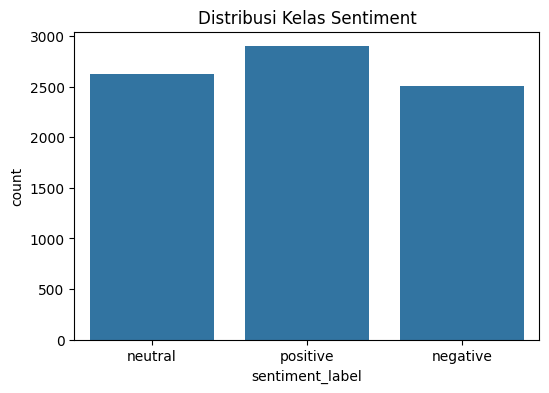

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment_label", data=df)
plt.title("Distribusi Kelas Sentiment")
plt.show()

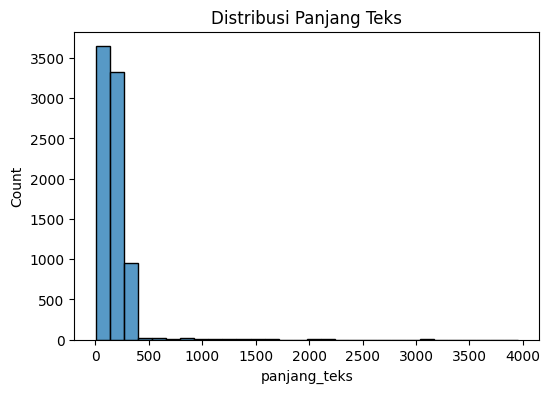

In [ ]:
df["panjang_teks"] = df["final_text"].astype(str).apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df["panjang_teks"], bins=30)
plt.title("Distribusi Panjang Teks")
plt.show()

#5.PRE-PROCESSING

In [ ]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment_label"])

num_classes = df["label"].nunique()
print("Jumlah kelas:", num_classes)

Jumlah kelas: 3


In [ ]:
df["final_text"] = df["final_text"].fillna("").astype(str)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["final_text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratifya=df["label"]
)

#6.MODEL 1 — NON-PRETRAINED LSTM(Neural Network Base)

##Tokenizer

In [ ]:
MAX_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

##Model LSTM

In [ ]:
model_lstm = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##Training

In [ ]:
history_lstm = model_lstm.fit(
    X_train_seq, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4811 - loss: 1.0104 - val_accuracy: 0.6656 - val_loss: 0.7553
Epoch 2/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8063 - loss: 0.4986 - val_accuracy: 0.7076 - val_loss: 0.7222
Epoch 3/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9338 - loss: 0.1983 - val_accuracy: 0.6874 - val_loss: 1.0088
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9696 - loss: 0.0966 - val_accuracy: 0.6952 - val_loss: 1.2768
Epoch 5/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9787 - loss: 0.0646 - val_accuracy: 0.6936 - val_loss: 1.3435


##Hasil Evaluasi

In [ ]:
y_pred_lstm = model_lstm.predict(X_test_seq).argmax(axis=1)

print("LSTM Classification Report")
print(classification_report(y_test, y_pred_lstm))

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM Classification Report
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       502
           1       0.67      0.66      0.66       524
           2       0.75      0.80      0.78       580

    accuracy                           0.72      1606
   macro avg       0.72      0.72      0.72      1606
weighted avg       0.72      0.72      0.72      1606



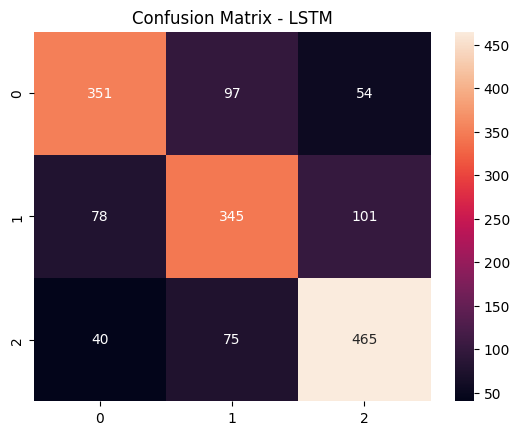

In [ ]:
cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - LSTM")
plt.show()

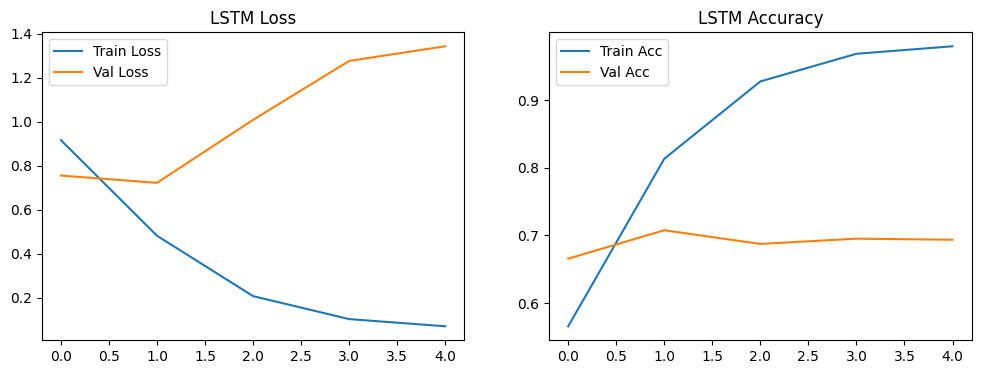

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy')
plt.legend()

plt.show()

##Uji Prediksi

In [ ]:
def predict_lstm(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN)
    pred = model_lstm.predict(pad).argmax(axis=1)[0]
    return le.inverse_transform([pred])[0]

print(predict_lstm("hahaha emang bner orang desa ga main saham"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
neutral


##Simpan Hasil Model

In [ ]:
os.makedirs("hasil_model_uap/LSTM", exist_ok=True)
os.makedirs("hasil_model_uap/ZIP", exist_ok=True)

In [ ]:
model_lstm.save("hasil_model_uap/LSTM/model_lstm.keras")

In [ ]:
with open("hasil_model_uap/LSTM/tokenizer_lstm.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
with zipfile.ZipFile("hasil_model_uap/ZIP/LSTM.zip", "w") as zipf:
    zipf.write("hasil_model_uap/LSTM/model_lstm.keras", arcname="model_lstm.keras")
    zipf.write("hasil_model_uap/LSTM/tokenizer_lstm.pkl", arcname="tokenizer_lstm.pkl")

In [ ]:
from google.colab import files

files.download("hasil_model_uap/ZIP/LSTM.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#7.MODEL 2 — PRETRAINED 1 DISTILBERT(TRANSFER LEARNING)

##Tokenizer

In [ ]:
tokenizer_db = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer_db(batch["final_text"], padding=True, truncation=True)

train_ds = Dataset.from_dict({"final_text": X_train.tolist(), "label": y_train.tolist()})
test_ds  = Dataset.from_dict({"final_text": X_test.tolist(), "label": y_test.tolist()})

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/6424 [00:00<?, ? examples/s]

Map:   0%|          | 0/1606 [00:00<?, ? examples/s]

##Model DistilBERT

In [ ]:
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./model_distilbert",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="no",
    report_to="none"
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [ ]:
trainer = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer_db,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-114009624.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.015152,0.717310
2,0.282200,1.002685,0.724159
3,0.239000,1.098694,0.733499
4,0.155200,1.242367,0.735990
5,0.114600,1.344739,0.732254


TrainOutput(global_step=2010, training_loss=0.19773991855222786, metrics={'train_runtime': 1627.8416, 'train_samples_per_second': 19.732, 'train_steps_per_second': 1.235, 'total_flos': 4254928724090880.0, 'train_loss': 0.19773991855222786, 'epoch': 5.0})

##Hasil Evaluasi

In [ ]:
pred = trainer.predict(test_ds)
y_pred_bert = np.argmax(pred.predictions, axis=1)

print("=== DistilBERT Classification Report ===")
print(classification_report(y_test, y_pred_bert, target_names=le.classes_))

=== DistilBERT Classification Report ===
              precision    recall  f1-score   support

    negative       0.75      0.73      0.74       502
     neutral       0.69      0.64      0.66       524
    positive       0.75      0.82      0.78       580

    accuracy                           0.73      1606
   macro avg       0.73      0.73      0.73      1606
weighted avg       0.73      0.73      0.73      1606



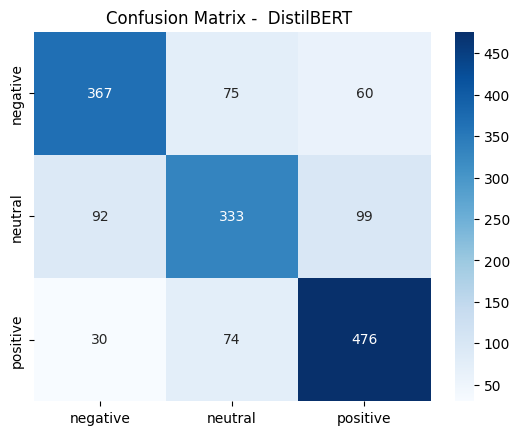

In [ ]:
cm = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix -  DistilBERT ")
plt.show()

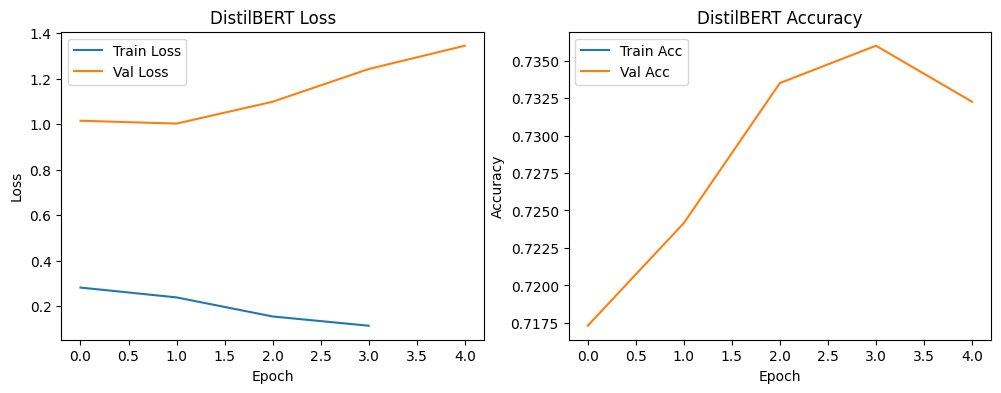

In [ ]:
logs = trainer.state.log_history

train_loss = []
eval_loss = []
train_acc = []
eval_acc = []
epochs = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "accuracy" in log:
        train_acc.append(log["accuracy"])
    if "eval_accuracy" in log:
        eval_acc.append(log["eval_accuracy"])

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.title("DistilBERT Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Acc")
plt.plot(eval_acc, label="Val Acc")
plt.title("DistilBERT Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

##Uji Prediksi

In [ ]:
def predict_distilbert(text):
    inputs = tokenizer_db(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model_db(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return le.inverse_transform([pred])[0]

print(predict_distilbert("layak masuk dalam daftar reshuflle 100 hari kinerja kabinet presiden"))

positive


##Simpan Hasil Model

In [ ]:
os.makedirs("hasil_model_uap/DistilBERT", exist_ok=True)

In [ ]:
model_distilbert.save_pretrained("hasil_model_uap/DistilBERT/model")
tokenizer_db.save_pretrained("hasil_model_uap/DistilBERT/tokenizer")

('hasil_model_uap/DistilBERT/tokenizer/tokenizer_config.json',
 'hasil_model_uap/DistilBERT/tokenizer/special_tokens_map.json',
 'hasil_model_uap/DistilBERT/tokenizer/vocab.txt',
 'hasil_model_uap/DistilBERT/tokenizer/added_tokens.json',
 'hasil_model_uap/DistilBERT/tokenizer/tokenizer.json')

In [ ]:
with zipfile.ZipFile("hasil_model_uap/ZIP/DistilBERT.zip", "w") as zipf:
    for folder in ["model", "tokenizer"]:
        for file in os.listdir(f"hasil_model_uap/DistilBERT/{folder}"):
            zipf.write(
                f"hasil_model_uap/DistilBERT/{folder}/{file}",
                arcname=f"{folder}/{file}"
            )

In [ ]:
from google.colab import files

files.download("hasil_model_uap/ZIP/DistilBERT.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#8.MODEL 3 — PRETRAINED 2 BERT BASE UNCASED (TRANSFER LEARNING)

##Tokenizer & Model

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_ds = Dataset.from_dict({"final_text": X_train.tolist(),"label": y_train.tolist()})
test_ds = Dataset.from_dict({"final_text": X_test.tolist(),"label": y_test.tolist()})

In [ ]:
def tokenize_function(batch):
    return tokenizer(
        batch["final_text"],
        padding=True,
        truncation=True,
        max_length=128
    )

In [ ]:
train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/6424 [00:00<?, ? examples/s]

Map:   0%|          | 0/1606 [00:00<?, ? examples/s]

##Format Tensor Pytorch

In [ ]:
train_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

##Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-base-uncased",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no",
    report_to="none"
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

In [ ]:
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_bert.train()

/tmp/ipython-input-4141744830.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.805161,0.650685
2,0.927100,0.711993,0.691158
3,0.677900,0.677345,0.721669
4,0.507500,0.722064,0.722914
5,0.379800,0.760305,0.729763


TrainOutput(global_step=2010, training_loss=0.6217956983034884, metrics={'train_runtime': 739.8791, 'train_samples_per_second': 43.412, 'train_steps_per_second': 2.717, 'total_flos': 2112800744355840.0, 'train_loss': 0.6217956983034884, 'epoch': 5.0})

##Hasil Evaluasi

In [ ]:
pred = trainer_bert.predict(test_ds)
y_pred_bert = np.argmax(pred.predictions, axis=1)

print("=== BERT Base Uncased Classification Report ===")
print(classification_report(y_test,y_pred_bert,target_names=le.classes_))

=== BERT Base Uncased Classification Report ===
              precision    recall  f1-score   support

    negative       0.79      0.66      0.72       502
     neutral       0.71      0.65      0.68       524
    positive       0.71      0.87      0.78       580

    accuracy                           0.73      1606
   macro avg       0.73      0.72      0.72      1606
weighted avg       0.73      0.73      0.73      1606



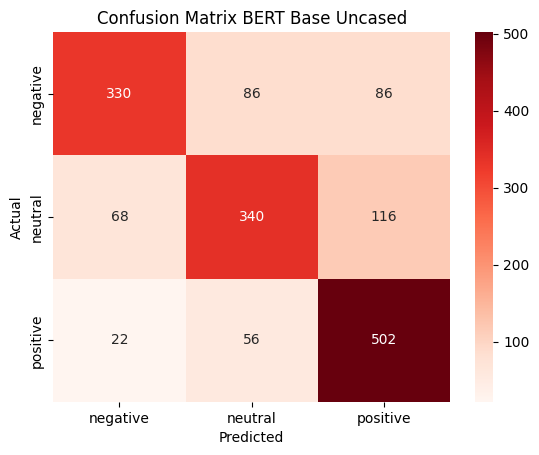

In [ ]:
cm_bert = confusion_matrix(y_test, y_pred_bert)

sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Reds"
)
plt.title("Confusion Matrix BERT Base Uncased")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

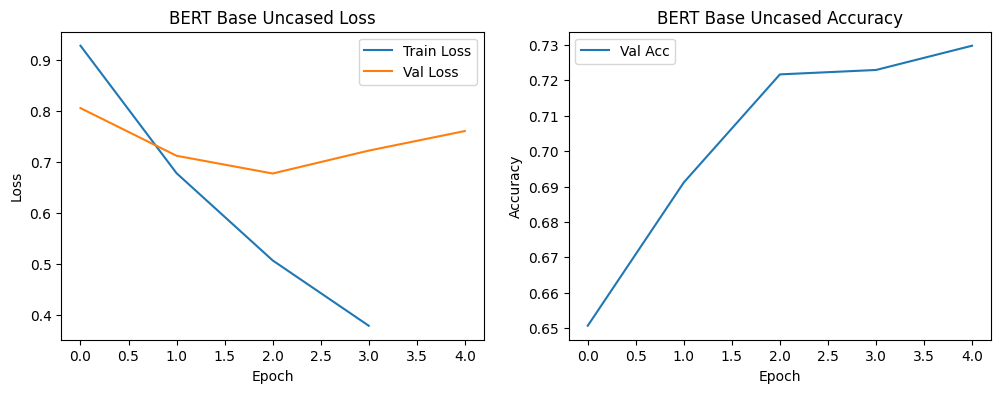

In [ ]:
logs_bert = pd.DataFrame(trainer_bert.state.log_history)

train_loss = logs_bert[logs_bert["loss"].notna()]["loss"].values
eval_loss  = logs_bert[logs_bert["eval_loss"].notna()]["eval_loss"].values
eval_acc   = logs_bert[logs_bert["eval_accuracy"].notna()]["eval_accuracy"].values

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.title("BERT Base Uncased Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(eval_acc, label="Val Acc")
plt.title("BERT Base Uncased Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

##Uji Prediksi

In [ ]:
import torch

def predict_bert(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )

    device = model_bert.device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model_bert(**inputs)

    pred = torch.argmax(outputs.logits, dim=1).item()
    return le.inverse_transform([pred])[0]

print(
    predict_bert("layak masuk dalam daftar reshuflle 100 hari kinerja kabinet presiden")
)

positive


##Simpan Hasil Model

In [ ]:
os.makedirs("hasil_model_uap/BERT_Base_Uncased", exist_ok=True)

In [ ]:
model_bert.save_pretrained("hasil_model_uap/BERT_Base_Uncased/model")
tokenizer.save_pretrained("hasil_model_uap/BERT_Base_Uncased/tokenizer")

('hasil_model_uap/BERT_Base_Uncased/tokenizer/tokenizer_config.json',
 'hasil_model_uap/BERT_Base_Uncased/tokenizer/special_tokens_map.json',
 'hasil_model_uap/BERT_Base_Uncased/tokenizer/vocab.txt',
 'hasil_model_uap/BERT_Base_Uncased/tokenizer/added_tokens.json',
 'hasil_model_uap/BERT_Base_Uncased/tokenizer/tokenizer.json')

In [ ]:
os.makedirs("hasil_model_uap/ZIP", exist_ok=True)

with zipfile.ZipFile(
    "hasil_model_uap/ZIP/BERT_Base_Uncased.zip", "w", zipfile.ZIP_DEFLATED
) as zipf:
    for folder in ["model", "tokenizer"]:
        folder_path = f"hasil_model_uap/BERT_Base_Uncased/{folder}"
        for file in os.listdir(folder_path):
            zipf.write(
                os.path.join(folder_path, file),
                arcname=f"{folder}/{file}"
            )

In [ ]:
from google.colab import files

files.download("hasil_model_uap/ZIP/BERT_Base_Uncased.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>